# Handwritten Digit Recognition

The goal of this project is to create a model classify grayscale 28 x 28 pixel images of handwritten digits. The data for each image is already in flattened format.

In [7]:
import sys
!{sys.executable} -m pip install tensorflow
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing, Previewing, and Preprocessing Datasets

Import the datasets.

In [8]:
train = pd.read_csv(r'C:\Datasets\traindigits.csv')
test = pd.read_csv(r'C:\Datasets\testdigits.csv')

Preview the dataset.

In [31]:
train.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
train.head(10).min(axis=1)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int64

In [36]:
train.head(10).max(axis=1)

0    255
1    255
2    255
3    255
4    254
5    255
6    255
7    255
8    255
9    255
dtype: int64

As shown above, the image values range from 0 to 255 (black to white).

Next we can preview the images as 28x28 arrays.

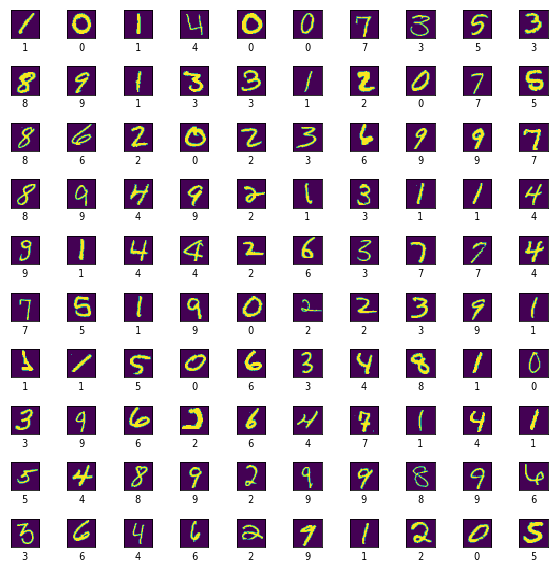

In [30]:
fig, ax = plt.subplots(10,10)
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(np.reshape(np.array(train.iloc[10*i+j,1:]),(28,28)))
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_xlabel(train.iloc[10*i+j,0])
fig.set_size_inches((8,8))
fig.tight_layout()

The numbers in the images all are fairly centered and scaled to about the same size, and they are mostly black and white (not much grey), so a simple neural network should work for this data set.

Before modeling, let's normalize all the images.

In [39]:
train.iloc[:,1:]=train.iloc[:,1:]/255
test = test/255

### Modeling

To avoid overfitting, we should perform cross validation to select model hyperparameters. We will do a 5-fold CV.

In [56]:
def CVsplit(i):
    if i==1:
        return (train.iloc[:8400,:],train.iloc[8400:,:])
    elif i==5:
        return (train.iloc[33600:,:],train.iloc[:33600,:])
    else:
        return (train.iloc[8400*(i-1):8400*i,:], train.iloc[:8400*(i-1),:].append(train.iloc[8400*i:,:]))

This function will perform the CV given specified hyperparameters.

In [78]:
def evalmodel(hidden, activation1, activation2, optimizer1, epochs1):
    meanacc = 0
    for i in range(1,6):
        CVsets = CVsplit(i)
        model = keras.Sequential([keras.layers.Dense(hidden, activation=activation1),
            keras.layers.Dense(10, activation = activation2)])
        model.compile(optimizer=optimizer1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        model.fit(np.array(CVsets[1].iloc[:,1:]), np.array(CVsets[1].label), epochs=epochs1, verbose = 0)
        resultloss, resultacc = model.evaluate(np.array(CVsets[0].iloc[:,1:]), np.array(CVsets[0].label))
        meanacc += resultacc
    meanacc /=5
    print('Hidden size',hidden, ', Activation 1:', str(activation1).split(' ')[1],', Activation 2:', str(activation2).split(' ')[1],', Optimizer:', optimizer1,',', epochs1, 'epochs. ','Accuracy: ',meanacc)

Hyperparameter optimization is performed below. First the activation functions are optimized.

In [85]:
for j in [tf.nn.relu,tf.nn.softmax]:
    for k in [tf.nn.relu,tf.nn.softmax]:
        evalmodel(125,j,k,'adam',5)

8400/8400 [==============================] - 2s 257us/sample - loss: 2.3026 - acc: 0.1014
Hidden size 125 , Activation 1: relu , Activation 2: relu , Optimizer: adam , 5 epochs.  Accuracy:  0.10088095217943191
8400/8400 [==============================] - 2s 229us/sample - loss: 0.1103 - acc: 0.9656
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: adam , 5 epochs.  Accuracy:  0.967976188659668
8400/8400 [==============================] - 2s 246us/sample - loss: 2.3026 - acc: 0.1014
Hidden size 125 , Activation 1: softmax , Activation 2: relu , Optimizer: adam , 5 epochs.  Accuracy:  0.09838095158338547
8400/8400 [==============================] - 2s 252us/sample - loss: 0.5995 - acc: 0.7971
Hidden size 125 , Activation 1: softmax , Activation 2: softmax , Optimizer: adam , 5 epochs.  Accuracy:  0.8443333387374878


Next, the number of epochs and the gradient descent method is optimized.

In [87]:
for l in ['RMSprop','adam','Nadam']:
    for m in [3,5,10]:
        evalmodel(125,tf.nn.relu,tf.nn.softmax,l,m)

8400/8400 [==============================] - 3s 306us/sample - loss: 0.1122 - acc: 0.9685
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: RMSprop , 3 epochs.  Accuracy:  0.9637380957603454
8400/8400 [==============================] - 3s 312us/sample - loss: 0.1035 - acc: 0.9707
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: RMSprop , 5 epochs.  Accuracy:  0.9683333277702332
8400/8400 [==============================] - 3s 317us/sample - loss: 0.1115 - acc: 0.9724
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: RMSprop , 10 epochs.  Accuracy:  0.9709285736083985
8400/8400 [==============================] - 3s 322us/sample - loss: 0.1105 - acc: 0.9670
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: adam , 3 epochs.  Accuracy:  0.9652618885040283
8400/8400 [==============================] - 3s 326us/sample - loss: 0.0935 - acc: 0.9715
Hidden size 125 , Activation 1: relu , Activation 2:

Finally, the size of the hidden layer is optimized.

In [90]:
for i in [125, 250, 400]:
    evalmodel(i,tf.nn.relu,tf.nn.softmax,'Nadam',10)

8400/8400 [==============================] - 3s 388us/sample - loss: 0.0960 - acc: 0.9732
Hidden size 125 , Activation 1: relu , Activation 2: softmax , Optimizer: Nadam , 10 epochs.  Accuracy:  0.971666669845581
8400/8400 [==============================] - 4s 443us/sample - loss: 0.1128 - acc: 0.9729
Hidden size 250 , Activation 1: relu , Activation 2: softmax , Optimizer: Nadam , 10 epochs.  Accuracy:  0.9724047541618347
8400/8400 [==============================] - 4s 459us/sample - loss: 0.1237 - acc: 0.9707
Hidden size 400 , Activation 1: relu , Activation 2: softmax , Optimizer: Nadam , 10 epochs.  Accuracy:  0.9729285717010498


A similar model with a similar number of total weights but using 2 hidden layers instead of 1 is evaluated below.

In [94]:
meanacc = 0
for i in range(1,6):
    CVsets = CVsplit(i)
    model = keras.Sequential([keras.layers.Dense(300, activation=tf.nn.relu),keras.layers.Dense(300, activation=tf.nn.relu),
        keras.layers.Dense(10, activation = tf.nn.softmax)])
    model.compile(optimizer='Nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(np.array(CVsets[1].iloc[:,1:]), np.array(CVsets[1].label), epochs=10, verbose = 0)
    resultloss, resultacc = model.evaluate(np.array(CVsets[0].iloc[:,1:]), np.array(CVsets[0].label))
    meanacc += resultacc
meanacc /=5
print('Accuracy: ',meanacc)

8400/8400 [==============================] - 4s 488us/sample - loss: 0.1124 - acc: 0.9762
Accuracy:  0.9747618913650513


The above model was the best performing model thus far, in terms of cross validation. The model will be fit and predictions made on the test set.

In [95]:
model.fit(np.array(train.iloc[:,1:]), np.array(train.label), epochs=10, verbose = 0)
resultloss, resultacc = model.evaluate(np.array(train.iloc[:,1:]), np.array(train.label))
print('Accuracy: ',resultacc)

42000/42000 [==============================] - 12s 288us/sample - loss: 0.0100 - acc: 0.9971
Accuracy:  0.99707144


In [96]:
predictions = model.predict(np.array(test))

In [102]:
pd.DataFrame(np.argmax(predictions,axis=1)).to_csv(r'C:\Datasets\digitspredict.csv')